# Collaborative Filtering

Use users' review ratings to define similarity between restaurants by creating a factorized utility matrix, using ALS. The resulting item matrix represents each restaurant as $k$-dimensional vector, from which the similariy matrix is defined. 

Steps
1. load data from leads, create pairs of user (Email) and property (ListingID), remove duplicates, and invalid emails
2. create indexers for emails, and listing ids ... keep to match back
3. run ALS for given $k$
4. compute similarity matrix $S_{i,j}$
5. find $p$ closest (i.e. most similar) properties, produce list.



## Code Preperation


In [10]:
import sys
import os
import pandas as pd
import numpy as np

In [9]:
# %load pyspark_init.py
"""
Load packages and create context objects...
"""
import os
import platform
import sys
if not 'sc' in globals(): ### vars():
    sys.path.append('/usr/hdp/2.4.2.0-258/spark/python')
    os.environ["SPARK_HOME"] = '/usr/hdp/2.4.2.0-258/spark'
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.11:1.2.0 pyspark-shell'
    import py4j
    import pyspark
    from pyspark.context import SparkContext, SparkConf
    from pyspark.sql import SQLContext, HiveContext
    from pyspark.storagelevel import StorageLevel
    sc = SparkContext()
    import atexit
    atexit.register(lambda: sc.stop())
    print("""Welcome to
          ____              __
         / __/__  ___ _____/ /__
        _\ \/ _ \/ _ `/ __/  '_/
       /__ / .__/\_,_/_/ /_/\_\   version %s
          /_/
    """ % sc.version)
else:
    print("""Already running
          ____              __
         / __/__  ___ _____/ /__
        _\ \/ _ \/ _ `/ __/  '_/
       /__ / .__/\_,_/_/ /_/\_\   version %s
          /_/
    """ % sc.version)

if not 'sqlCtx' in globals(): ## vars():
    sqlCtx = SQLContext(sc)
print 'Spark Context available as `sc`'
print 'Spark SQL Context (%s) available as `sqlCtx`'%str(type(sqlCtx))
print "Monitor this application at http://arc.insight.gsu.edu:8088/proxy/"+sc.applicationId



Already running
          ____              __
         / __/__  ___ _____/ /__
        _\ \/ _ \/ _ `/ __/  '_/
       /__ / .__/\_,_/_/ /_/\_\   version 1.6.1
          /_/
    
Spark Context available as `sc`
Spark SQL Context (<class 'pyspark.sql.context.HiveContext'>) available as `sqlCtx`
Monitor this application at http://arc.insight.gsu.edu:8088/proxy/application_1484597252711_0274


###  Functions

In [ ]:
cbsa_df.to_json(jp(DATADIR, 'cbsa_table.json'))


Top 10 CBSAs by number of properties.

In [9]:

#from ipywidgets import interactive, interact

In [ ]:
#@interact
#def get_leads(CBSA_loc=cbsa_selection):
#    global CBSA, CBSA_title
#    CBSA=CBSA_loc
#    #CBSA_title = cbsa_df[cbsa_df.CBSAcode==CBSA_loc].NAME[0]
#    #print(CBSA_title)

## Data 
Get Yelp Reviews

In [11]:
review_df = sqlCtx.read.json('/user/pmolnar/yelp/data/review')

In [12]:
review_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- votes: struct (nullable = true)
 |    |-- cool: long (nullable = true)
 |    |-- funny: long (nullable = true)
 |    |-- useful: long (nullable = true)



We interested in `business_id` as our item, `user_id` as user, and `stars` for the ratings

In [13]:
res = review_df.groupBy(['user_id', 'business_id']).count()
res.take(10)

[Row(user_id=u'T3OqI85mcQe8cBT0nEffsw', business_id=u'TRLMm_deLvlPNmGNqRxcow', count=1),
 Row(user_id=u'EeOBT-RohoF3yWAG36dTDw', business_id=u'TRLMm_deLvlPNmGNqRxcow', count=1),
 Row(user_id=u'Rma9IWA8ZWqxU0OWURBSSA', business_id=u'vvPzcOhbQn5fLQUAIxcP6A', count=1),
 Row(user_id=u'99GvIpyZocAgXJzYcRyrzQ', business_id=u'cjD2yGRhT5yaSj_KP55Ptw', count=1),
 Row(user_id=u'gcNwo1fHiVzzN9LfNZAl0g', business_id=u'cjD2yGRhT5yaSj_KP55Ptw', count=1),
 Row(user_id=u'OfIxjYLy81RjIaFTkBEPjA', business_id=u'd3ni6cKglu4L3JeveOqQDQ', count=1),
 Row(user_id=u'l3qwLaCRoGlZNwyjG970Aw', business_id=u'd3ni6cKglu4L3JeveOqQDQ', count=1),
 Row(user_id=u'UzGXrITqog05M-mb_9DnxA', business_id=u'uUj-mziX-qv0e1k0jkpI7g', count=1),
 Row(user_id=u'heE73sRnRL8vf5_Vz6p8nQ', business_id=u'QnnssZJOLZquRp0hqeK1dA', count=1),
 Row(user_id=u'2kJIyFyhsvYL3V75hFkF7g', business_id=u'oQOo1rebP4bieLEEoVHbQg', count=1)]

In [14]:
number_of_pairs = res.count()
number_of_pairs

2439535

In [16]:
print res.explain()

== Physical Plan ==
TungstenAggregate(key=[user_id#6,business_id#0], functions=[(count(1),mode=Final,isDistinct=false)], output=[user_id#6,business_id#0,count#8L])
+- TungstenExchange hashpartitioning(user_id#6,business_id#0,200), None
   +- TungstenAggregate(key=[user_id#6,business_id#0], functions=[(count(1),mode=Partial,isDistinct=false)], output=[user_id#6,business_id#0,count#11L])
      +- Scan JSONRelation[user_id#6,business_id#0] InputPaths: hdfs://backend-0-2.insight.gsu.edu:8020/user/pmolnar/yelp/data/review
None


In [17]:
print "We have %d ratings."%(number_of_pairs)

We have 2439535 ratings.


In [18]:
import pyspark.sql.functions as F
import pyspark.ml.feature as MLftr

uidIndexer = MLftr.StringIndexer(inputCol='user_id', outputCol='user_idx', handleInvalid='skip').fit(res)
bidIndexer = MLftr.StringIndexer(inputCol='business_id', outputCol='business_idx', handleInvalid='skip').fit(res)

In [26]:
##uidIndexer.save('uidIndexer.dat')
##bidIndexer.save('bidndexer.dat')

Now we need use the indexers to relabel our records

In [19]:
res2 = uidIndexer.transform(res)
res3 = bidIndexer.transform(res2)

In [20]:
res3.printSchemaSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- count: long (nullable = false)
 |-- user_idx: double (nullable = true)
 |-- business_idx: double (nullable = true)



In [23]:
indexedRatings = res3.withColumn('rating', res3['count'].cast('float')) \
    .withColumn('user', res3.user_idx.cast('integer')) \
    .withColumn('item', res3.business_idx.cast('integer'))

In [24]:
indexedRatings.printSchemaintSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- count: long (nullable = false)
 |-- user_idx: double (nullable = true)
 |-- business_idx: double (nullable = true)
 |-- rating: float (nullable = false)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)



In [35]:
num_leads = indexedleads.count()
num_leads

61450

In [42]:
listings_table = indexedleads.select('ListingId', 'PropertyIndex', 'item').groupBy('ListingId', 'PropertyIndex', 'item').count()

In [21]:
indexedleads.agg(F.max('count'), F.min('count')).collect()

[Row(max(count)=26, min(count)=1)]

In [31]:
freq_user_leads = indexedleads.groupBy('count').count().toPandas()
freq_user_leads.columns = ['cnt', 'freq']

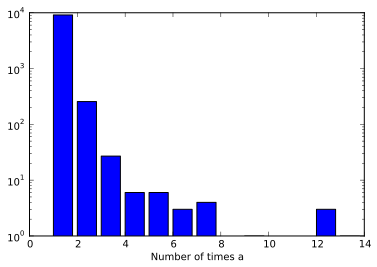

In [92]:
%matplotlib inline
fig = plt.figure()
plt.bar(freq_user_leads.cnt, freq_user_leads.freq)
plt.gca().set_yscale("log", nonposy='clip')
plt.xlabel('Number of times a ')

The majority of email-listing pairs appear only once. Though, there seem to be duplicates. In the first iteration we may ignore the fact and just cound every pair once.

## Ratings Matrix

In [25]:
## just use the user item pairs, set rating to 1.0
ratings = indexedRatings.select(['user', 'item']).withColumn('rating', F.lit(1.0))

In [23]:
ratings.show()

+-----+----+------+
| user|item|rating|
+-----+----+------+
| 6452|  64|   1.0|
| 1641|  36|   1.0|
| 5980|  28|   1.0|
| 6580|  26|   1.0|
| 1650|   8|   1.0|
|  597|  86|   1.0|
|13832|   8|   1.0|
|20914|   4|   1.0|
| 2069|  74|   1.0|
|46586|   2|   1.0|
|11672|  24|   1.0|
| 3175|   4|   1.0|
| 6711|  18|   1.0|
|33206|   2|   1.0|
|  754|  76|   1.0|
| 2658|  30|   1.0|
|22401|   3|   1.0|
|    6|  69|   1.0|
| 1829|  89|   1.0|
|  671|  29|   1.0|
+-----+----+------+
only showing top 20 rows



Building receommender model (ALS) and extract feature matrices for consumers (users) and listings (items)

In [27]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.clustering import KMeans, KMeansModel
## from pyspark.ml.linalg import Vectors     # version 2 has them in 'ml'
from pyspark.mllib.linalg import Vectors 

In [28]:
print(ALS.__doc__)


    Alternating Least Squares (ALS) matrix factorization.

    ALS attempts to estimate the ratings matrix `R` as the product of
    two lower-rank matrices, `X` and `Y`, i.e. `X * Yt = R`. Typically
    these approximations are called 'factor' matrices. The general
    approach is iterative. During each iteration, one of the factor
    matrices is held constant, while the other is solved for using least
    squares. The newly-solved factor matrix is then held constant while
    solving for the other factor matrix.

    This is a blocked implementation of the ALS factorization algorithm
    that groups the two sets of factors (referred to as "users" and
    "products") into blocks and reduces communication by only sending
    one copy of each user vector to each product block on each
    iteration, and only for the product blocks that need that user's
    feature vector. This is achieved by pre-computing some information
    about the ratings matrix to determine the "out-links" of eac

In [29]:
RANK = 100
maxIter = 15
als = ALS(rank=RANK, maxIter=maxIter, seed=0)

In [30]:
mdl = als.fit(ratings)

In [31]:
item_mat = mdl.itemFactors
#item_mat.rdd.take(5)
item_mat.rdd.count()

84194

In [32]:
item_mat_df = item_mat.rdd.map(lambda r: [r.id] + r.features).toDF()

## Find Similar Properties
We use the feature matrix on items compute similarity of properties based on users submitted leads.

In [44]:
item_mat.count()

664

In [33]:
item_mat.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



Use `item_mat`, a DataFrame with `id` and `features` to create a **distance matrix** $D$.

Steps:
1. Convert `features` into dense vectors
2. Outer join of item matrix on itself:
    1. with renamed columns
    2. filter upper triangle ($row$ < $col$)
3. Calculate squared distance

In [34]:
# 1.
item_ftr = item_mat.rdd.map(lambda r: (Vectors.dense(r.features), r.id)).toDF(['X', 'id'])
#item_ftr.show()


# 2. 
joined_mat = item_ftr.join(item_ftr.withColumnRenamed('id', 'b_id').withColumnRenamed('X', 'b_X'), how='outer')
joined_mat_ut = joined_mat.filter(joined_mat.id!=joined_mat.b_id)
#joined_mat_ut.show()

In [35]:
joined_mat_ut.printSchema()

root
 |-- X: vector (nullable = true)
 |-- id: long (nullable = true)
 |-- b_X: vector (nullable = true)
 |-- b_id: long (nullable = true)



In [36]:
joined_mat_ut.show()

+--------------------+---+--------------------+----+
|                   X| id|                 b_X|b_id|
+--------------------+---+--------------------+----+
|[0.02424747869372...|  0|[0.02343193814158...|  10|
|[0.02424747869372...|  0|[0.02283312380313...|  20|
|[0.02424747869372...|  0|[0.02754783444106...|  30|
|[0.02424747869372...|  0|[0.02349585853517...|  40|
|[0.02424747869372...|  0|[0.02263843640685...|  50|
|[0.02424747869372...|  0|[0.00692668883129...|  60|
|[0.02424747869372...|  0|[0.02742943167686...|  70|
|[0.02424747869372...|  0|[0.02468242868781...|  80|
|[0.02424747869372...|  0|[0.02787471376359...|  90|
|[0.02424747869372...|  0|[0.02701982297003...| 100|
|[0.02424747869372...|  0|[0.02377360872924...| 110|
|[0.02424747869372...|  0|[0.02317129075527...| 120|
|[0.02424747869372...|  0|[0.02382670901715...| 130|
|[0.02424747869372...|  0|[0.00681572128087...| 140|
|[0.02424747869372...|  0|[0.00725018279626...| 150|
|[0.02424747869372...|  0|[0.02326913364231...

In [37]:
indexedRatings.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- count: long (nullable = false)
 |-- user_idx: double (nullable = true)
 |-- business_idx: double (nullable = true)
 |-- rating: float (nullable = false)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)



In [38]:
jjmat = indexedRatings.withColumnRenamed('business_id', 'a_business_id').join(
    indexedRatings.withColumnRenamed('business_id', 'b_business_id')\
        .join(joined_mat_ut, indexedRatings.item==joined_mat_ut.b_id), indexedRatings.item==joined_mat_ut.id)

In [39]:
jjmat.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- a_business_id: string (nullable = true)
 |-- count: long (nullable = false)
 |-- user_idx: double (nullable = true)
 |-- business_idx: double (nullable = true)
 |-- rating: float (nullable = false)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- user_id: string (nullable = true)
 |-- b_business_id: string (nullable = true)
 |-- count: long (nullable = false)
 |-- user_idx: double (nullable = true)
 |-- business_idx: double (nullable = true)
 |-- rating: float (nullable = false)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- X: vector (nullable = true)
 |-- id: long (nullable = true)
 |-- b_X: vector (nullable = true)
 |-- b_id: long (nullable = true)



Compute Distance Matrix

In [ ]:
import math

# 3.
dist_mat = jjmat.rdd.map(lambda r: (r.a_business_id, r.b_business_id, r.id, r.b_id, math.sqrt(r.X.squared_distance(r.b_X)))).toDF(['a_business_id', 'b_business_id', 'a_id', 'b_id', 'distance'])
dist_mat.show()

In [57]:
dist_mat.count()

440232

In [39]:
dist_mat.sort('distance').show()

+----+----+--------------------+
|a_id|b_id|            distance|
+----+----+--------------------+
|  74|   7|8.870951586288792E-5|
|   7|  74|8.870951586288792E-5|
|  41|  43|1.116469780882443...|
|  43|  41|1.116469780882443...|
|  29|  50|1.263022728250230...|
|  50|  29|1.263022728250230...|
|   4|  49|1.433852329223916...|
|  49|   4|1.433852329223916...|
|  14|  17|1.496814454634857...|
|  17|  14|1.496814454634857...|
|  44|   5|1.500953684710987...|
|   5|  44|1.500953684710987...|
|  69|  90|1.506363371048501E-4|
|  90|  69|1.506363371048501E-4|
|  60|   0|1.555116364584669...|
|   0|  60|1.555116364584669...|
|  53|  10|1.572409140812167...|
|  10|  53|1.572409140812167...|
|   2|   9|1.584770531539547...|
|   9|   2|1.584770531539547...|
+----+----+--------------------+
only showing top 20 rows



In [40]:
dist_mat.agg(F.min('distance').alias('dmin'), F.max('distance').alias('dmax')).collect()

[Row(dmin=8.870951586288792e-05, dmax=1.6572038883890563)]

In [58]:
dist_df = dist_mat.toPandas()

In [ ]:
def get_top_ten(gdf):
    nrow = min(gdf.shape[0], 10)
    topten = gdf.sort_values(by='distance', ascending=True).head(nrow)
    topten['var_dist'] = ['nb%d_dist'%i for i in xrange(nrow)]
    topten['var_id'] = ['nb%d_id'%i for i in xrange(nrow)]
    pv_dist = topten.pivot(index='a_ListingId', columns='var_dist', values='distance')
    pv_id = topten.pivot(index='a_ListingId', columns='var_id', values='b_ListingId')
    return pd.concat([pv_dist, pv_id], axis=1)

In [60]:
neighbors_df = dist_df.groupby(by='a_id').apply(get_top_ten)

In [61]:
neighbors_df.head()

,,nb0_dist,nb1_dist,nb2_dist,nb3_dist,nb4_dist,nb5_dist,nb6_dist,nb7_dist,nb8_dist,nb9_dist,nb0_id,nb1_id,nb2_id,nb3_id,nb4_id,nb5_id,nb6_id,nb7_id,nb8_id,nb9_id
a_id,a_ListingId,,,,,,,,,,,,,,,,,,,,
0,184441,0.001064,0.001683,0.001847,0.002791,0.002969,0.003269,0.003762,0.003843,0.004057,0.004244,669,100025633,100025832,188875,87302,274,100028458,738,722,19456
1,6863,0.001816,0.001818,0.002395,0.002755,0.002836,0.002978,0.003024,0.003070,0.003265,0.003858,722,15071,84266,87302,188875,66,100026922,80240,2400,32
2,100025832,0.001187,0.001847,0.001973,0.002473,0.002696,0.003258,0.003489,0.003638,0.003648,0.003841,100025633,184441,669,188875,87302,274,19456,100026922,722,80240
3,66,0.000470,0.000737,0.001419,0.001521,0.001836,0.001989,0.002112,0.002155,0.002171,0.002978,80240,100026922,722,2400,15071,19,19456,87302,50,6863
4,28,0.003372,0.003782,0.004525,0.005421,0.005682,0.005786,0.005930,0.006398,0.006484,0.006971,14270,291,25084,14427,45,100012078,5,34148,40526,2428
